# *Práctica LAB3 IA Generativa - Clasificar Texto con Codificador Transformer*


GRUPO: A08

CARLOS OCON GARAY.

PEDRO GARCIA SILGO

Utilizar un Codificador Transformer para clasificar las noticias de Reuters en 46 temas mutuamente excluyentes. Como cada noticia debe clasificarse en una sola categoría, es un problema de "clasificación multiclase de una sola etiqueta".

El Reuters dataset es un conjunto de noticias breves y sus temas, publicado por Reuters en 1986. Son 46 temas diferentes; algunos temas están más representados que otros, pero cada uno tiene, al menos, 10 ejemplos en el conjunto de entrenamiento.

Al igual que IMDB y MNIST, el conjunto de datos de Reuters viene empaquetado como parte de Keras.

"""

from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

"""

Se importan las librerías necesarias

## Librerías

In [16]:
# Librerías
import numpy as np
from keras.datasets import reuters
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import MultiHeadAttention, Dropout

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fosky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Se carga el dataset que se va a utilizar, en este caso; [Reuters](https://keras.io/api/datasets/reuters/)

In [17]:
# Cargar datos
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
vocab = reuters.get_word_index()


# Comprobar parámetros a entrenar y testear
print(f"Datos de entrenamiento: {len(train_data)}")
print(f"Datos de test: {len(test_data)}")
print(f"Vocabulario: {len(vocab)}")


Datos de entrenamiento: 8982
Datos de test: 2246
Vocabulario: 30979


In [18]:
# Se invierte el vocabulario para decodificar el texto
vocab_inv = dict([(value,key) for (key, value) in vocab.items()])

def decode_text(enc_text:list[int]):
  return ' '.join([vocab_inv.get(i - 3, '?') for i in enc_text])
print(f"Texto sin codificar: {decode_text(train_data[1])}")
print(f"Texto codificado: {train_data[1]}")
print(f"Etiqueta: {train_labels[1]}")

Texto sin codificar: ? generale de banque sa lt ? br and lt heller overseas corp of chicago have each taken 50 pct stakes in ? company sa ? factors generale de banque said in a statement it gave no financial details of the transaction sa ? ? turnover in 1986 was 17 5 billion belgian francs reuter 3
Texto codificado: [1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]
Etiqueta: 4


En el texto sin codificar, las primeras palabras no se representan.

Además, los signos de puntuación se han quitado. De esta manera, el modelo saldrá con mejor informacion.

In [19]:
# Número de palabras en los grupos de entrenamiento y test
def palabras(data: np.ndarray[list[int]], unk_idx:int = 2):
  T = 0
  count = 0
  for t in data:
    count += np.sum(np.array(t)==unk_idx)
    T += len(t)

  return count/T*100

print(f'Proporción OOV tokens en train: {palabras(train_data)}')
print(f'Proporción OOV tokens en test: {palabras(test_data)}')

Proporción OOV tokens en train: 2.731176165949761
Proporción OOV tokens en test: 2.76709875258935


La proporción de las palabras que hay en ambos grupos es parecida, por lo que no habra baja representabilidad.

Además, hay que comporbar el tamaño de los textos. Igual la mayoría no supera las 200 palabras y, para optimizar el modelo, es un dato bastante importante a la hora de modelizarlo.

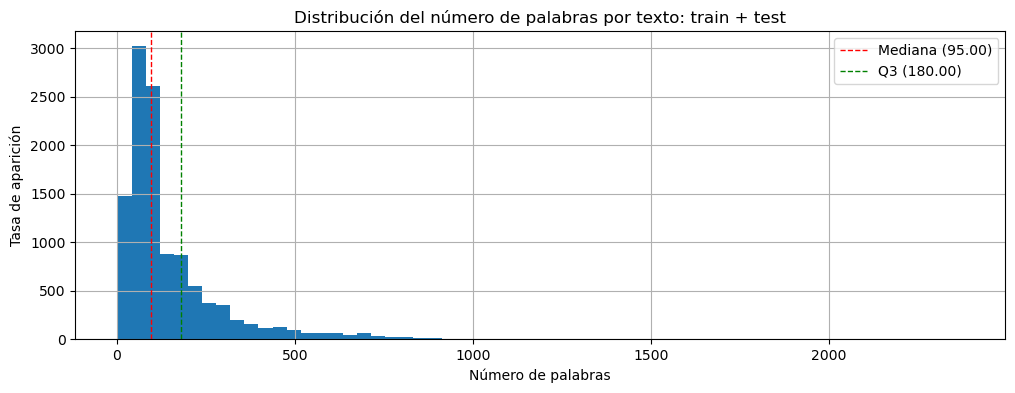

In [20]:
def num_palabras(lengths: np.ndarray[int]):
  plt.figure(figsize=(12, 4))

  # Histograma
  plt.hist(lengths, bins=60)
  plt.xlabel('Número de palabras')
  plt.ylabel('Tasa de aparición')
  plt.title('Distribución del número de palabras por texto: train + test')
  plt.grid(True)

  # Cálculo de la mediana
  mean_length = np.median(lengths)
  plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Mediana ({mean_length:.2f})')

  # Cálculo del 3r cuartil
  q3_length = np.percentile(lengths, 75)
  plt.axvline(q3_length, color='green', linestyle='dashed', linewidth=1, label=f'Q3 ({q3_length:.2f})')

  # Leyenda
  plt.legend()

  plt.show()

# Cálculo de longitud de los textos
lengths = np.array([len(x) for x in np.concatenate([train_data, test_data])])
num_palabras(lengths)

Se ve que el 75% de los textos no tienen más de 180 palabras y que la mitad de los textos ni superan las 100. Se puede establecer unas 140 palabras para no perder demasiada información.

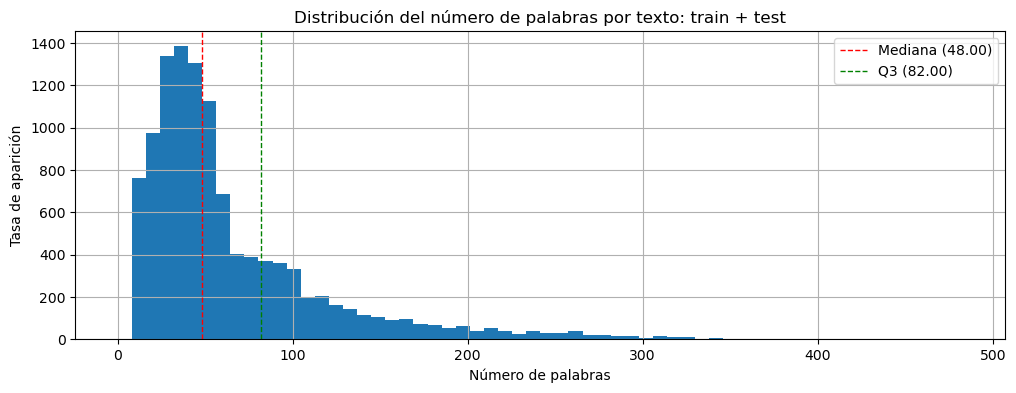

In [21]:
# Máxima longitud de los textos
MAXLEN = 100

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

# Crear tf.datasets
x_train_padded1 = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAXLEN)
x_val_padded1 = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=MAXLEN)
y_train_one_hot1 = tf.one_hot(y_train, depth=46)
y_val_one_hot1 = tf.one_hot(y_val, depth=46)


# Eliminar stopwords
stop_words = stopwords.words('english')
stop_words_idx = [vocab.get(w) for w in stop_words]
stop_words_idx = np.array([x for x in stop_words_idx if x is not None])

train_data2 = [np.setdiff1d(lst, stop_words_idx) for lst in train_data]
test_data2 = [np.setdiff1d(lst, stop_words_idx) for lst in test_data]

# Calculate lengths of lists
lengths = np.array([len(x) for x in (train_data2 + test_data2)])
num_palabras(lengths)

Además, para mejorar el modelo, se han eliminado las palabras que no aportan nada al texto (las stopwords)

Pero, como se ha elegido un máximo de 140 palabras, los textos que tengan menos, se tendrá que aplicar un embeding.

In [22]:
# Dividir los datos en conjuntos de entrenamiento y validación 2
x_train2, x_val2, y_train2, y_val2 = train_test_split(train_data2, train_labels, test_size=0.1, random_state=42)


In [23]:
# Crear tf.datasets
x_train_padded2 = tf.keras.preprocessing.sequence.pad_sequences(x_train2, maxlen=MAXLEN)
x_val_padded2 = tf.keras.preprocessing.sequence.pad_sequences(x_val2, maxlen=MAXLEN)
y_train_one_hot2 = tf.one_hot(y_train2, depth=46)
y_val_one_hot2 = tf.one_hot(y_val2, depth=46)

assert tf.math.reduce_all((y_val_one_hot1 == y_val_one_hot2)).numpy()


Una vez hecho esto, se crean el modelo.

In [24]:
# Parámetros fijos
NUM_CLASSES = 46
VOCAB_SIZE = max([max(sequence) for sequence in train_data]) + 1 # <- 10000 de acuerdo al parám. num_words al cargar el dataset

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config


In [28]:
# Definir la clase PositionalEmbedding
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        # Wrap the TensorFlow function in a Lambda layer
        return layers.Lambda(lambda x: tf.math.not_equal(x, 0))(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

## Modelo 1

Para este ejercicio, el modelo no tiene dependencia ninguna, ni secuencial ni temporal, por lo que se usará solo el *Encoder*.

In [37]:
# Parámetros
embedding_dim = 128
num_heads = 8
dropout_rate = 0.2
dense_dim = 64

# Construir el modelo
def crear_modelo1():
  inputs = layers.Input(shape=(MAXLEN,))
  embedding_layer = PositionalEmbedding(MAXLEN, VOCAB_SIZE, embedding_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerEncoder(embedding_dim, dense_dim, num_heads)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(dropout_rate)(x)
  outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compilación del modelo
  model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

  return model

# Resumen del modelo
modelo1 = crear_modelo1()
modelo1.summary()

C:\Users\fosky\anaconda3\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'transformer_encoder_5' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)   │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ positional_embedding_5        │ (None, 100, 128)          │       1,292,800 │ input_layer_10[0][0]       │
│ (PositionalEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_9 (Lambda)             │ (None, 100)               │               0 │ input_layer_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_5         │ (None, 100, 128)          │         544,576 │ positional_embedding_5[0]… │
│ (TransformerEncoder)          │                           │                 │ lambda_9[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_3    │ (None, 128)               │               0 │ transformer_encoder_5[0][… │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 128)               │               0 │ global_average_pooling1d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 46)                │           5,934 │ dropout_9[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,843,310 (7.03 MB)

 Trainable params: 1,843,310 (7.03 MB)

 Non-trainable params: 0 (0.00 B)

Y se entrena y evalua el modelo

### Modelo 1.1

In [38]:
# Entrenamiento del modelo1 en el dataset1, sin embeding
modelo11 = crear_modelo1()
history11 = modelo1.fit(x_train_padded1, y_train_one_hot1,
                      epochs=20,
                      batch_size=32,
                      validation_data=(x_val_padded1, y_val_one_hot1))

Epoch 1/20


C:\Users\fosky\anaconda3\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'transformer_encoder_6' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5374 - loss: 1.8801 - val_accuracy: 0.7041 - val_loss: 1.2511
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7513 - loss: 0.9831 - val_accuracy: 0.7564 - val_loss: 1.0378
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8174 - loss: 0.7206 - val_accuracy: 0.7875 - val_loss: 0.9839
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8763 - loss: 0.5060 - val_accuracy: 0.7742 - val_loss: 1.0618
Epoch 5/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8976 - loss: 0.4405 - val_accuracy: 0.7753 - val_loss: 1.0955
Epoch 6/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9204 - loss: 0.3467 - val_accuracy: 0.7853 - val_loss: 1.1757
Epoch 7/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9301 - loss: 0.2872 - val_accuracy: 0.7419 - val_loss: 1.3104
Epoch 8/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9347 - loss: 0.2492 - val_accurac

Se ve que en el entrenamiento alcanza un 95% de acierto, pero cuando se comprueba la verificación apenas llega al 80%. Esto puede deberse al sobreentrenamiento al no haber aplicado el embeding.

Se puede comprobar con el dataset tratado:

### Modelo 1.2

In [39]:
# Entrenamiento del modelo1 en el dataset2, con embeding
modelo12 = crear_modelo1()
history12 = modelo12.fit(x_train_padded2, y_train_one_hot2,
                         epochs=20, batch_size=32,
                         validation_data=(x_val_padded2, y_val_one_hot2))


Epoch 1/20


C:\Users\fosky\anaconda3\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'transformer_encoder_7' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.5274 - loss: 1.9312 - val_accuracy: 0.7019 - val_loss: 1.1811
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7648 - loss: 0.9863 - val_accuracy: 0.7575 - val_loss: 1.0461
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8332 - loss: 0.6956 - val_accuracy: 0.7786 - val_loss: 0.9923
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8847 - loss: 0.4899 - val_accuracy: 0.7497 - val_loss: 1.1663
Epoch 5/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9158 - loss: 0.3658 - val_accuracy: 0.7108 - val_loss: 1.2485
Epoch 6/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9260 - loss: 0.3132 - val_accuracy: 0.8165 - val_loss: 1.0456
Epoch 7/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9378 - loss: 0.2640 - val_accuracy: 0.7842 - val_loss: 1.0925
Epoch 8/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9467 - loss: 0.2082 - val_accurac

A pesar de no haber mejorado mucho, algo a mejorado. Puede ser por el propio modelo y que con otro se vea mejor, pero así de primeras se puede empezar a deducir que el dataset con el embeding funciona mejor que el primero.

Esto se debe a que al quitar las palabras más frecuentes, por lo tanto menos importantes, se quita mucho ruido del modelo.

Pero, para asegurarse, se hará un segundo modelo con 2 bloques Encorer para ver si realmente la eliminación del ruido influye mucho.

## Modelo 2

Para este modelo, a parte de añadir otro bloque Encoder, se utiliza el optimizador adam, se aumenta el radio de dropout y se aumenta el tamaño del batch.

A parte, se usará una técnica de regularización llamada *label smoothing* que usa una distribución de etiquetas suavizada. Es decir, en vez de tener 0 o 1, habrá valores entre medias (muy aproximados a 0 y a 1)

In [40]:
# Parámetros
embedding_dim = 128
num_heads = 8
dropout_rate = 0.4
dense_dim = 64

# Construir el modelo
def crear_modelo2():
  inputs = layers.Input(shape=(MAXLEN,))
  embedding_layer = PositionalEmbedding(MAXLEN, VOCAB_SIZE, embedding_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerEncoder(embedding_dim, dense_dim, num_heads)
  x = transformer_block(x)
  transformer_block2 = TransformerEncoder(embedding_dim, dense_dim, num_heads)
  x = transformer_block2(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(dropout_rate)(x)
  outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

  model2 = keras.Model(inputs=inputs, outputs=outputs)

  # Compilación del modelo
  model2.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=["accuracy"])
  return model2

# Resumen del modelo
modelo2 = crear_modelo2()
modelo2.summary()

C:\Users\fosky\anaconda3\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'transformer_encoder_8' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)   │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ positional_embedding_8        │ (None, 100, 128)          │       1,292,800 │ input_layer_16[0][0]       │
│ (PositionalEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_18 (Lambda)            │ (None, 100)               │               0 │ input_layer_16[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_8         │ (None, 100, 128)          │         544,576 │ positional_embedding_8[0]… │
│ (TransformerEncoder)          │                           │                 │ lambda_18[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_9         │ (None, 100, 128)          │         544,576 │ transformer_encoder_8[0][… │
│ (TransformerEncoder)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_6    │ (None, 128)               │               0 │ transformer_encoder_9[0][… │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_16 (Dropout)          │ (None, 128)               │               0 │ global_average_pooling1d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_26 (Dense)              │ (None, 46)                │           5,934 │ dropout_16[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,387,886 (9.11 MB)

 Trainable params: 2,387,886 (9.11 MB)

 Non-trainable params: 0 (0.00 B)

### Modelo 2.1

In [43]:
# Entrenamiento del modelo1 en el dataset1, sin embeding
history_21 = modelo2.fit(x_train_padded1, y_train_one_hot1,
                      epochs=20,
                      batch_size=32,
                      validation_data=(x_val_padded1, y_val_one_hot1))

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.5364 - loss: 2.3164 - val_accuracy: 0.7597 - val_loss: 1.5310
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7966 - loss: 1.4333 - val_accuracy: 0.7775 - val_loss: 1.4359
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.8700 - loss: 1.1861 - val_accuracy: 0.7898 - val_loss: 1.4208
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.9162 - loss: 1.0232 - val_accuracy: 0.7798 - val_loss: 1.4630
Epoch 5/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.9425 - loss: 0.9464 - val_accuracy: 0.7875 - val_loss: 1.4691
Epoch 6/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.9500 - loss: 0.9098 - val_accuracy: 0.7798 - val_loss: 1.5255
Epoch 7/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.9558 - loss: 0.8882 - val_accuracy: 0.7887 - val_loss: 1.5343
Epoch 8/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.9606 - loss: 0.8607 - 

### Modelo 2.2

In [44]:
modelo22 = crear_modelo2()
history22 = modelo22.fit(x_train_padded2, y_train_one_hot2,
                         epochs=20, batch_size=32,
                         validation_data=(x_val_padded2, y_val_one_hot2))

C:\Users\fosky\anaconda3\Lib\site-packages\keras\src\layers\layer.py:877: UserWarning: Layer 'transformer_encoder_10' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.5097 - loss: 2.3982 - val_accuracy: 0.7275 - val_loss: 1.6289
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7871 - loss: 1.4736 - val_accuracy: 0.7720 - val_loss: 1.5146
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.8802 - loss: 1.1710 - val_accuracy: 0.7864 - val_loss: 1.4716
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.9123 - loss: 1.0455 - val_accuracy: 0.8142 - val_loss: 1.4232
Epoch 5/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.9419 - loss: 0.9508 - val_accuracy: 0.8087 - val_loss: 1.3842
Epoch 6/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.9525 - loss: 0.9028 - val_accuracy: 0.8009 - val_loss: 1.4062
Epoch 7/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.9557 - loss: 0.8872 - val_accuracy: 0.7964 - val_loss: 1.4729
Epoch 8/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.9578 - loss: 0.8647 - 

En este caso, la precisión ha empeorado, pero esto puede deberse a la cantidad de épocas que se han puesto.

## Resultados

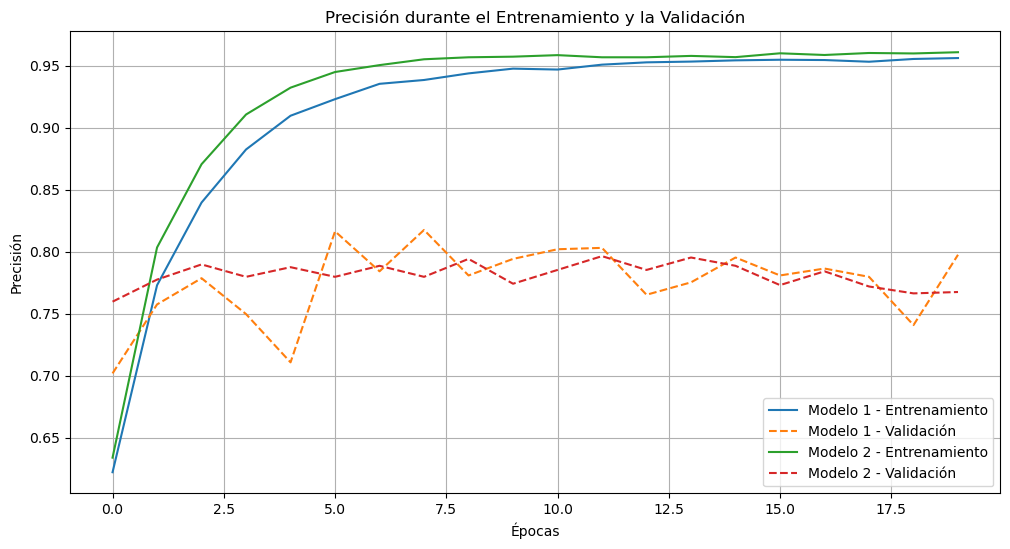

In [45]:
# Precisión durante el entrenamiento y la validación
plt.figure(figsize=(12, 6))
plt.plot(history12.history['accuracy'], label='Modelo 1 - Entrenamiento', linestyle='-')
plt.plot(history12.history['val_accuracy'], label='Modelo 1 - Validación', linestyle='--')

plt.plot(history_21.history['accuracy'], label='Modelo 2 - Entrenamiento', linestyle='-')
plt.plot(history_21.history['val_accuracy'], label='Modelo 2 - Validación', linestyle='--')

plt.title('Precisión durante el Entrenamiento y la Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

Los modelos se han ejecutado con 20 épocas, pero parece ser que con 5 bastaban no solo para que se entrenase, sino que para que la validación se mantuviera en un numero más alto del que ha termiando quedando.

A pesar de ello, ambos han obtenido grandes resultados, pero lo que les ha unido también es el sobreentrenamiento (pero al eliminar épocas esto se soluciona). Otra manera de poder tratar el problema es incluir las palabras que se han eliminado como "no importantes" por si alguna de ellas sí que influye a la hora del aprendizaje.

Y si se tuviera que elegir uno, se escogería el modelo 2, pero con 5 épocas, ya que alcanza el 95% de aciertos con una validación de más del 80%.